# Warehouse Optimization - Zipf 1.5, 2 agenti, A* planner

**Parametry:**
- Mapa: 9×9
- Agenti: 2
- Planner: **A*** (space-time)
- Distribuce: **Zipf 1.5** (strmější - lepší pro surrogate modely)
- Populace: 100
- Generace: 50

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from warehouse import Warehouse, OrderGenerator
from mapd_solver import MAPDSimulator
from surrogate import SurrogateModel, extract_features, compare_models
from evolution import run_evolution, collect_initial_data
from baselines import run_all_baselines

%matplotlib inline

In [2]:
# Parametry experimentu
GRID_SIZE = 9
N_AGENTS = 2
SIM_STEPS = 500
ORDER_LAMBDA = 0.4
SEED = 42

# Planner
PLANNER_TYPE = "astar"

# Distribuce - Zipf 1.5 (strmější distribuce pro lepší surrogate predikce)
DISTRIBUTION = "zipf"
ZIPF_PARAM = 1.5

# EA parametry
POP_SIZE = 100
N_GENERATIONS = 50
REAL_EVAL_INTERVAL = 10

# Surrogate parametry
INIT_SAMPLES = 100

## 1. Porovnání distribucí

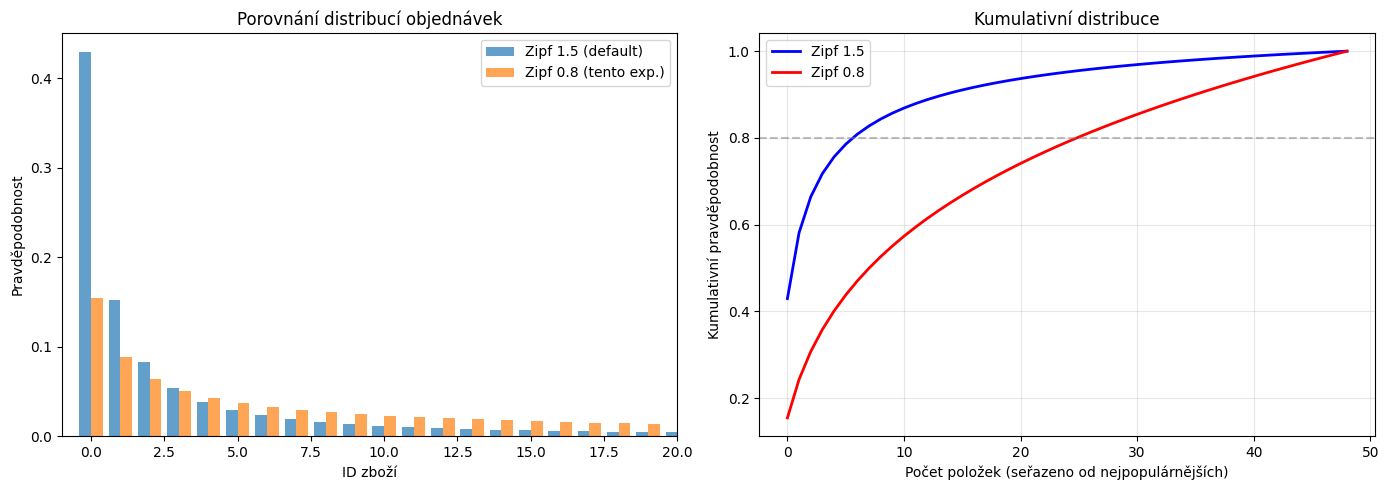

Statistiky distribuce:
  Zipf 1.5: max=0.4295, min=0.0013, ratio=343.0x
  Zipf 0.8: max=0.1545, min=0.0069, ratio=22.5x


In [3]:
# Porovnání Zipf 1.5 vs Zipf 0.8
n_goods = (GRID_SIZE - 2) ** 2

og_default = OrderGenerator(n_goods, distribution="zipf", zipf_param=1.5, seed=SEED)
og_mild = OrderGenerator(n_goods, distribution="zipf", zipf_param=0.8, seed=SEED)

probs_default = og_default.get_probabilities()
probs_mild = og_mild.get_probabilities()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
x = np.arange(n_goods)
width = 0.4
ax1.bar(x - width/2, probs_default, width, label='Zipf 1.5 (default)', alpha=0.7)
ax1.bar(x + width/2, probs_mild, width, label='Zipf 0.8 (tento exp.)', alpha=0.7)
ax1.set_xlabel('ID zboží')
ax1.set_ylabel('Pravděpodobnost')
ax1.set_title('Porovnání distribucí objednávek')
ax1.legend()
ax1.set_xlim(-1, 20)

# Kumulativní distribuce
ax2 = axes[1]
ax2.plot(np.cumsum(np.sort(probs_default)[::-1]), 'b-', label='Zipf 1.5', linewidth=2)
ax2.plot(np.cumsum(np.sort(probs_mild)[::-1]), 'r-', label='Zipf 0.8', linewidth=2)
ax2.axhline(0.8, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Počet položek (seřazeno od nejpopulárnějších)')
ax2.set_ylabel('Kumulativní pravděpodobnost')
ax2.set_title('Kumulativní distribuce')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Statistiky distribuce:")
print(f"  Zipf 1.5: max={probs_default.max():.4f}, min={probs_default.min():.4f}, ratio={probs_default.max()/probs_default.min():.1f}x")
print(f"  Zipf 0.8: max={probs_mild.max():.4f}, min={probs_mild.min():.4f}, ratio={probs_mild.max()/probs_mild.min():.1f}x")

## 2. Vytvoření skladu

In [4]:
wh = Warehouse(GRID_SIZE, GRID_SIZE)
og = OrderGenerator(wh.n_inner, distribution=DISTRIBUTION, zipf_param=ZIPF_PARAM, seed=SEED)

print(f"Velikost: {GRID_SIZE}x{GRID_SIZE}")
print(f"Počet vnitřních pozic (zboží): {wh.n_inner}")
print(f"Počet delivery points: {len(wh.get_delivery_points())}")
print(f"Distribuce: {DISTRIBUTION} s parametrem {ZIPF_PARAM}")
print(f"Počet agentů: {N_AGENTS}")
print(f"Planner: {PLANNER_TYPE.upper()}")

Velikost: 9x9
Počet vnitřních pozic (zboží): 49
Počet delivery points: 32
Distribuce: zipf s parametrem 1.5
Počet agentů: 2
Planner: ASTAR


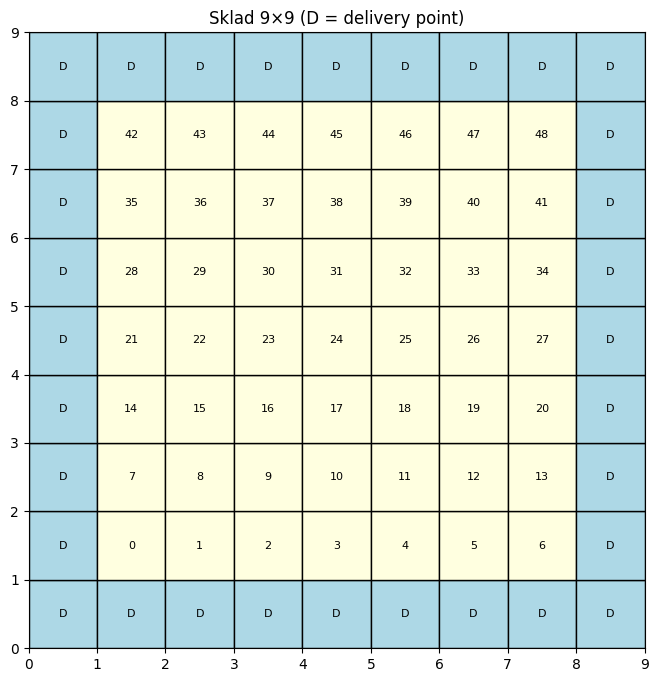

In [5]:
# Vizualizace prázdného skladu
fig, ax = plt.subplots(figsize=(8, 8))

for y in range(GRID_SIZE):
    for x in range(GRID_SIZE):
        if x == 0 or x == GRID_SIZE-1 or y == 0 or y == GRID_SIZE-1:
            color = 'lightblue'
            label = 'D'
        else:
            color = 'lightyellow'
            inner_idx = (y - 1) * (GRID_SIZE - 2) + (x - 1)
            label = str(inner_idx)
        
        ax.add_patch(plt.Rectangle((x, y), 1, 1, facecolor=color, edgecolor='black'))
        ax.text(x + 0.5, y + 0.5, label, ha='center', va='center', fontsize=8)

ax.set_xlim(0, GRID_SIZE)
ax.set_ylim(0, GRID_SIZE)
ax.set_aspect('equal')
ax.set_title(f'Sklad {GRID_SIZE}×{GRID_SIZE} (D = delivery point)')
plt.show()

## 3. Baseline metody

In [6]:
print(f"Používám A* planner - mělo by být rychlejší než SAT\n")

baseline_results = run_all_baselines(
    wh, og, n_agents=N_AGENTS,
    random_samples=50,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)

Používám A* planner - mělo by být rychlejší než SAT

Running baselines (planner: astar)...

1. Random baseline:
  Random: 20/50 samples, best so far: 0.3560
  Random: 40/50 samples, best so far: 0.3560

2. Greedy baseline:
  Greedy fitness: 0.1900

3. Inverse greedy baseline:
  Inverse greedy fitness: 0.1020


In [7]:
print("Souhrn baseline:")
print(f"  Random:         best={baseline_results['random']['best_fitness']:.4f}, "
      f"mean={baseline_results['random']['mean_fitness']:.4f}")
print(f"  Greedy:         {baseline_results['greedy']['fitness']:.4f}")
print(f"  Inverse Greedy: {baseline_results['inverse_greedy']['fitness']:.4f}")

Souhrn baseline:
  Random:         best=0.3560, mean=0.2065
  Greedy:         0.1900
  Inverse Greedy: 0.1020


## 4. Sběr dat pro surrogate model

In [8]:
print(f"Sbírám {INIT_SAMPLES} vzorků s {N_AGENTS} agenty (A* planner)...\n")
start_time = time.time()

features_list, fitness_list, layouts_list = collect_initial_data(
    wh, og, n_agents=N_AGENTS,
    n_samples=INIT_SAMPLES,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)

collect_time = time.time() - start_time
print(f"\nČas sběru dat: {collect_time:.1f}s")

X_data = np.array(features_list)
y_data = np.array(fitness_list)

print(f"Rozsah fitness: [{y_data.min():.4f}, {y_data.max():.4f}]")
print(f"Průměr fitness: {y_data.mean():.4f} ± {y_data.std():.4f}")

Sbírám 100 vzorků s 2 agenty (A* planner)...

  Collected 10/100 samples
  Collected 20/100 samples
  Collected 30/100 samples
  Collected 40/100 samples
  Collected 50/100 samples
  Collected 60/100 samples
  Collected 70/100 samples
  Collected 80/100 samples
  Collected 90/100 samples
  Collected 100/100 samples

Čas sběru dat: 206.6s
Rozsah fitness: [0.1300, 0.3360]
Průměr fitness: 0.2056 ± 0.0598


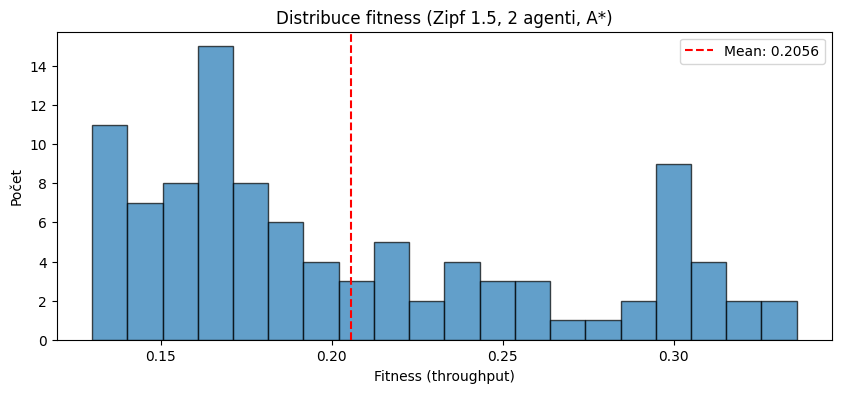

In [9]:
# Histogram fitness hodnot
plt.figure(figsize=(10, 4))
plt.hist(y_data, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(y_data.mean(), color='red', linestyle='--', label=f'Mean: {y_data.mean():.4f}')
plt.xlabel('Fitness (throughput)')
plt.ylabel('Počet')
plt.title(f'Distribuce fitness (Zipf {ZIPF_PARAM}, {N_AGENTS} agenti, A*)')
plt.legend()
plt.show()

## 5. Porovnání surrogate modelů

In [10]:
model_comparison = compare_models(X_data, y_data, cv=5)

print("Cross-validation R² skóre:")
for name, scores in model_comparison.items():
    print(f"  {name:10s}: {scores['r2_mean']:.3f} ± {scores['r2_std']:.3f}")

best_model_name = max(model_comparison.keys(),
                      key=lambda k: model_comparison[k]['r2_mean'])
print(f"\nNejlepší model: {best_model_name}")

Cross-validation R² skóre:
  linear    : -0.492 ± 0.569
  ridge     : -0.054 ± 0.246
  gp        : 0.093 ± 0.068
  rf        : 0.125 ± 0.114

Nejlepší model: rf


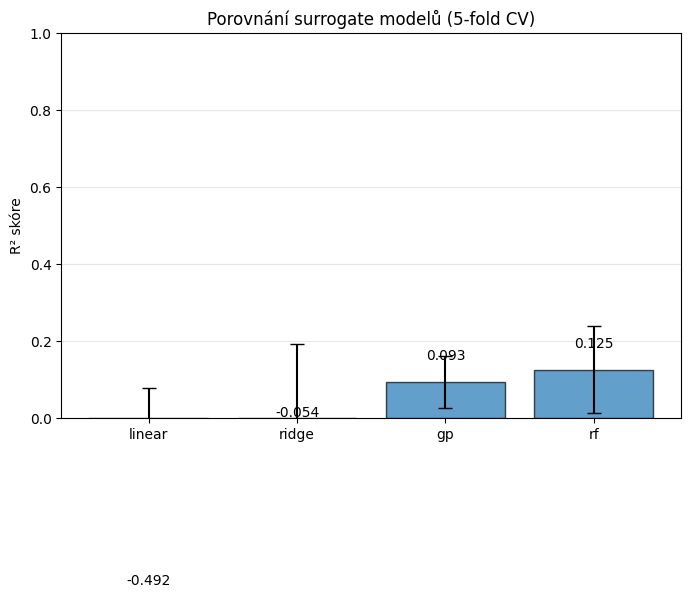

In [11]:
# Vizualizace R² skóre
fig, ax = plt.subplots(figsize=(8, 5))

names = list(model_comparison.keys())
means = [model_comparison[n]['r2_mean'] for n in names]
stds = [model_comparison[n]['r2_std'] for n in names]

bars = ax.bar(names, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='black')
ax.set_ylabel('R² skóre')
ax.set_title('Porovnání surrogate modelů (5-fold CV)')
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{mean:.3f}', ha='center', va='bottom')

plt.show()

## 6. Evoluce BEZ surrogate

In [12]:
print(f"Populace: {POP_SIZE}, Generace: {N_GENERATIONS}")
print(f"Agenti: {N_AGENTS}, Planner: {PLANNER_TYPE.upper()}\n")

ea_no_surrogate = run_evolution(
    wh, og, n_agents=N_AGENTS,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    use_surrogate=False,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)

print(f"\nVýsledky bez surrogate:")
print(f"  Nejlepší fitness: {ea_no_surrogate['best_fitness']:.4f}")
print(f"  Reálných evaluací: {ea_no_surrogate['real_evals']}")
print(f"  Čas: {ea_no_surrogate['wall_time']:.1f}s")

Populace: 100, Generace: 50
Agenti: 2, Planner: ASTAR

Gen 0: best=0.3860, avg=0.2110, std=0.0596
Gen 10: best=0.3820, avg=0.2447
Gen 20: best=0.3640, avg=0.2381
Gen 30: best=0.4000, avg=0.2432
Gen 40: best=0.3580, avg=0.2560
Gen 50: best=0.3600, avg=0.2609

Výsledky bez surrogate:
  Nejlepší fitness: 0.4000
  Reálných evaluací: 5100
  Čas: 5897.9s


## 7. Evoluce SE surrogate

In [13]:
print(f"Populace: {POP_SIZE}, Generace: {N_GENERATIONS}")
print(f"Surrogate model: {best_model_name}")
print(f"Reálná evaluace každých {REAL_EVAL_INTERVAL} generací\n")

ea_with_surrogate = run_evolution(
    wh, og, n_agents=N_AGENTS,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    use_surrogate=True,
    surrogate_type=best_model_name,
    real_eval_interval=REAL_EVAL_INTERVAL,
    sim_steps=SIM_STEPS,
    order_lambda=ORDER_LAMBDA,
    seed=SEED,
    verbose=True,
    planner_type=PLANNER_TYPE
)

print(f"\nVýsledky se surrogate:")
print(f"  Nejlepší fitness: {ea_with_surrogate['best_fitness']:.4f}")
print(f"  Reálných evaluací: {ea_with_surrogate['real_evals']}")
print(f"  Surrogate evaluací: {ea_with_surrogate['surrogate_evals']}")
print(f"  Čas: {ea_with_surrogate['wall_time']:.1f}s")

Populace: 100, Generace: 50
Surrogate model: rf
Reálná evaluace každých 10 generací

Gen 0: best=0.3600, avg=0.2136, std=0.0671
Gen 10: best=0.3520, avg=0.2416, real_evals=176
Gen 20: best=0.3400, avg=0.2369, real_evals=253
Gen 30: best=0.3540, avg=0.2548, real_evals=322
Gen 40: best=0.3760, avg=0.2529, real_evals=395
Gen 50: best=0.3660, avg=0.2598, real_evals=477

Výsledky se surrogate:
  Nejlepší fitness: 0.3760
  Reálných evaluací: 477
  Surrogate evaluací: 3431
  Čas: 813.6s


## 8. Finální porovnání

In [14]:
print(f"{'Metoda':<20} {'Fitness':>10} {'Real evals':>12} {'Čas':>10}")
print("-" * 55)

results_table = [
    ("Random (best)", baseline_results['random']['best_fitness'], "-", "-"),
    ("Random (mean)", baseline_results['random']['mean_fitness'], "-", "-"),
    ("Greedy", baseline_results['greedy']['fitness'], "-", "-"),
    ("Inverse Greedy", baseline_results['inverse_greedy']['fitness'], "-", "-"),
    ("EA bez surrogate", ea_no_surrogate['best_fitness'],
     ea_no_surrogate['real_evals'], f"{ea_no_surrogate['wall_time']:.1f}s"),
    ("EA se surrogate", ea_with_surrogate['best_fitness'],
     ea_with_surrogate['real_evals'], f"{ea_with_surrogate['wall_time']:.1f}s"),
]

for name, fitness, evals, time_str in results_table:
    print(f"{name:<20} {fitness:>10.4f} {str(evals):>12} {str(time_str):>10}")

savings = (1 - ea_with_surrogate['real_evals'] / ea_no_surrogate['real_evals']) * 100
print(f"\nÚspora reálných evaluací: {savings:.1f}%")

speedup = ea_no_surrogate['wall_time'] / ea_with_surrogate['wall_time']
print(f"Speedup: {speedup:.2f}x")

Metoda                  Fitness   Real evals        Čas
-------------------------------------------------------
Random (best)            0.3560            -          -
Random (mean)            0.2065            -          -
Greedy                   0.1900            -          -
Inverse Greedy           0.1020            -          -
EA bez surrogate         0.4000         5100    5897.9s
EA se surrogate          0.3760          477     813.6s

Úspora reálných evaluací: 90.6%
Speedup: 7.25x


## 9. Vizualizace výsledků

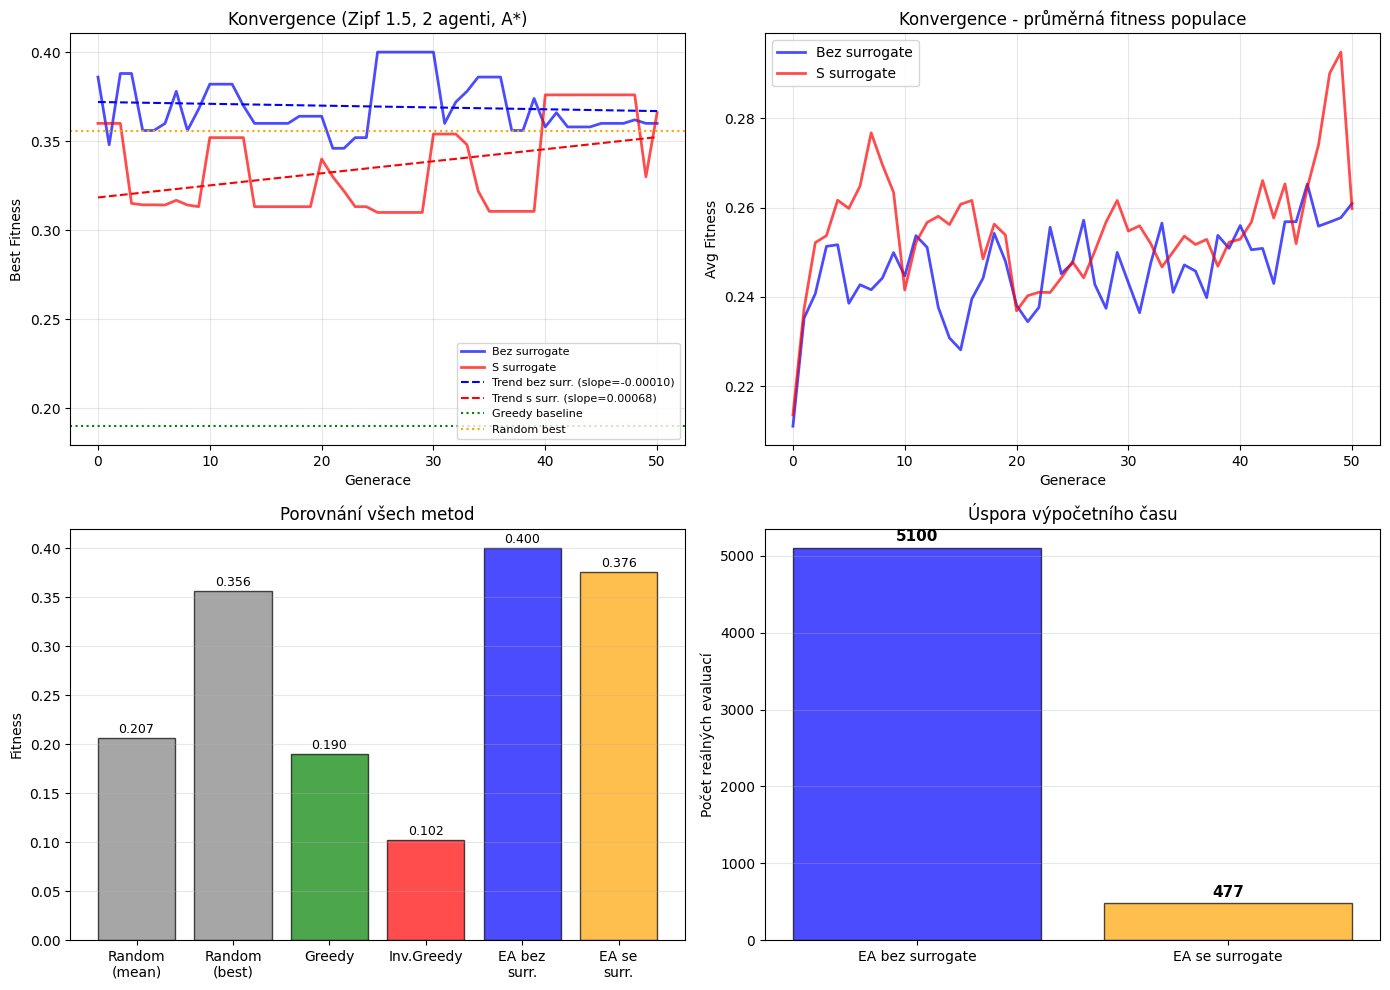

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Graf 1: Konvergence - best fitness
ax1 = axes[0, 0]
gens = np.arange(len(ea_no_surrogate['fitness_history']))
ax1.plot(gens, ea_no_surrogate['fitness_history'], 'b-',
         label='Bez surrogate', linewidth=2, alpha=0.7)
ax1.plot(gens, ea_with_surrogate['fitness_history'], 'r-',
         label='S surrogate', linewidth=2, alpha=0.7)

z1 = np.polyfit(gens, ea_no_surrogate['fitness_history'], 1)
z2 = np.polyfit(gens, ea_with_surrogate['fitness_history'], 1)
ax1.plot(gens, np.poly1d(z1)(gens), 'b--', linewidth=1.5,
         label=f'Trend bez surr. (slope={z1[0]:.5f})')
ax1.plot(gens, np.poly1d(z2)(gens), 'r--', linewidth=1.5,
         label=f'Trend s surr. (slope={z2[0]:.5f})')

ax1.axhline(y=baseline_results['greedy']['fitness'], color='g',
            linestyle=':', label='Greedy baseline')
ax1.axhline(y=baseline_results['random']['best_fitness'], color='orange',
            linestyle=':', label='Random best')

ax1.set_xlabel('Generace')
ax1.set_ylabel('Best Fitness')
ax1.set_title(f'Konvergence (Zipf {ZIPF_PARAM}, {N_AGENTS} agenti, A*)')
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(True, alpha=0.3)

# Graf 2: Konvergence - avg fitness
ax2 = axes[0, 1]
ax2.plot(gens, ea_no_surrogate['avg_fitness_history'], 'b-',
         label='Bez surrogate', linewidth=2, alpha=0.7)
ax2.plot(gens, ea_with_surrogate['avg_fitness_history'], 'r-',
         label='S surrogate', linewidth=2, alpha=0.7)
ax2.set_xlabel('Generace')
ax2.set_ylabel('Avg Fitness')
ax2.set_title('Konvergence - průměrná fitness populace')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Graf 3: Porovnání metod
ax3 = axes[1, 0]
methods = ['Random\n(mean)', 'Random\n(best)', 'Greedy', 'Inv.Greedy',
           'EA bez\nsurr.', 'EA se\nsurr.']
values = [
    baseline_results['random']['mean_fitness'],
    baseline_results['random']['best_fitness'],
    baseline_results['greedy']['fitness'],
    baseline_results['inverse_greedy']['fitness'],
    ea_no_surrogate['best_fitness'],
    ea_with_surrogate['best_fitness']
]
colors = ['gray', 'gray', 'green', 'red', 'blue', 'orange']
bars = ax3.bar(methods, values, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Fitness')
ax3.set_title('Porovnání všech metod')
ax3.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# Graf 4: Počet evaluací
ax4 = axes[1, 1]
eval_methods = ['EA bez surrogate', 'EA se surrogate']
eval_counts = [ea_no_surrogate['real_evals'], ea_with_surrogate['real_evals']]
bars = ax4.bar(eval_methods, eval_counts, color=['blue', 'orange'],
               alpha=0.7, edgecolor='black')
ax4.set_ylabel('Počet reálných evaluací')
ax4.set_title('Úspora výpočetního času')
ax4.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, eval_counts):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{val}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('project_zipf08_2agents_astar_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Vizualizace nejlepšího rozložení

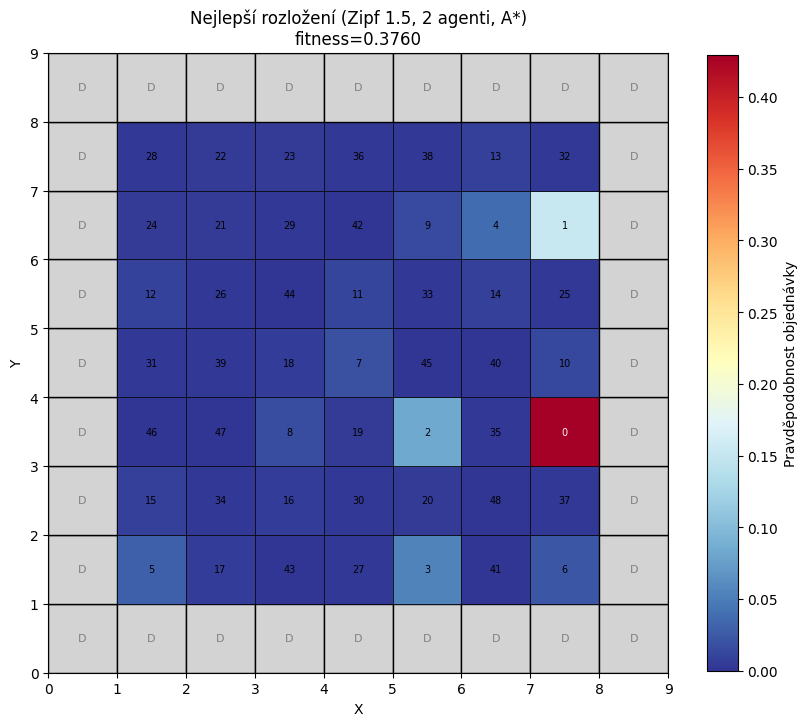

In [16]:
best_layout = ea_with_surrogate['best_individual']
wh.set_layout(best_layout)

fig, ax = plt.subplots(figsize=(10, 10))
probs = og.get_probabilities()

for y in range(GRID_SIZE):
    for x in range(GRID_SIZE):
        if x == 0 or x == GRID_SIZE-1 or y == 0 or y == GRID_SIZE-1:
            color = 'lightgray'
            ax.add_patch(plt.Rectangle((x, y), 1, 1,
                        facecolor=color, edgecolor='black', linewidth=1))
            ax.text(x + 0.5, y + 0.5, 'D', ha='center', va='center',
                   fontsize=8, color='gray')
        else:
            inner_idx = (y - 1) * (GRID_SIZE - 2) + (x - 1)
            goods_id = best_layout[inner_idx]
            prob = probs[goods_id]
            intensity = prob / probs.max()
            color = plt.cm.RdYlBu_r(intensity)

            ax.add_patch(plt.Rectangle((x, y), 1, 1,
                        facecolor=color, edgecolor='black', linewidth=0.5))
            ax.text(x + 0.5, y + 0.5, f'{goods_id}', ha='center', va='center',
                   fontsize=7, color='white' if intensity > 0.5 else 'black')

ax.set_xlim(0, GRID_SIZE)
ax.set_ylim(0, GRID_SIZE)
ax.set_aspect('equal')
ax.set_title(f'Nejlepší rozložení (Zipf {ZIPF_PARAM}, {N_AGENTS} agenti, A*)\n'
             f'fitness={ea_with_surrogate["best_fitness"]:.4f}')
ax.set_xlabel('X')
ax.set_ylabel('Y')

sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r,
                            norm=plt.Normalize(vmin=0, vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Pravděpodobnost objednávky')

plt.savefig('project_zipf08_2agents_astar_best_layout.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Závěr

### Shrnutí experimentu

**Konfigurace:**
- **Zipf 1.5** (strmější distribuce - top 5 položek = 76% objednávek)
- 2 agenti
- **A* planner** (rychlejší než SAT)

**Výhody Zipf 1.5:**
- Větší rozdíly mezi layouty
- Surrogate modely dosahují pozitivního R²
- Layout má větší vliv na throughput

In [17]:
print("=" * 50)
print("EXPERIMENT DOKONČEN")
print("=" * 50)
print(f"\nParametry:")
print(f"  Distribuce: Zipf {ZIPF_PARAM}")
print(f"  Agenti: {N_AGENTS}")
print(f"  Planner: {PLANNER_TYPE.upper()}")
print(f"  Mapa: {GRID_SIZE}x{GRID_SIZE}")
print(f"\nVýsledky:")
print(f"  Nejlepší fitness (EA se surrogate): {ea_with_surrogate['best_fitness']:.4f}")
print(f"  Úspora evaluací: {savings:.1f}%")
print(f"  Speedup: {speedup:.2f}x")

EXPERIMENT DOKONČEN

Parametry:
  Distribuce: Zipf 1.5
  Agenti: 2
  Planner: ASTAR
  Mapa: 9x9

Výsledky:
  Nejlepší fitness (EA se surrogate): 0.3760
  Úspora evaluací: 90.6%
  Speedup: 7.25x
